<a href="https://colab.research.google.com/github/katiegaertner/Bankruptcy-Classification/blob/main/CompanyBankrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Read in Data and Packages

In [7]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [8]:
from google.colab import files
uploaded = files.upload()

Saving bankruptdata.csv to bankruptdata (1).csv


In [9]:
import io
bankrupt = pd.read_csv(io.BytesIO(uploaded['bankruptdata.csv']))



```
# This is formatted as code
```

# Exploratory Data Analysis

In [10]:
#bankrupt.info()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Bankruptcy in Companies')

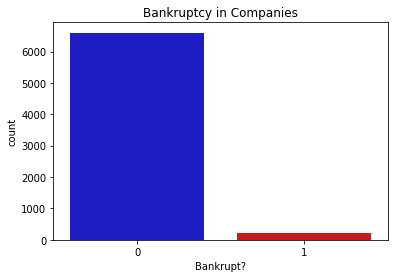

In [11]:
bankrupt['Bankrupt?'].value_counts()
colors = ['#0101DF', '#DF0101']
sns.countplot('Bankrupt?', data=bankrupt, palette=colors)
plt.title('Bankruptcy in Companies')

In [12]:
bankrupt.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

In [13]:
#keep only ratios
b2 = bankrupt.loc[:, (bankrupt.gt(-2) & bankrupt.lt(2)).all()]
b2.shape

(6819, 72)

In [14]:
cor_matrix = b2.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
b3 = b2.drop(to_drop, axis=1)

In [15]:
x = b3.drop(['Bankrupt?'], axis=1)
y = b3['Bankrupt?']

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [17]:
#Model Evaluation Tools

def confusion_matrix(model, x, y, title):
  y_pred=model.predict(x)
  cnf_matrix = metrics.confusion_matrix(y, y_pred)
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title(title, y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

def model_metrics(model, xtest, ytest):
  y_pred = model.predict(xtest)
  cnf_matrix = metrics.confusion_matrix(ytest, y_pred)
  print(model)
  print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
  print("  Compare with Null Accuracy:", max(ytest.mean(), 1 - ytest.mean()))
  print("Precision:",metrics.precision_score(ytest, y_pred))
  print("Sensitivity:",metrics.recall_score(ytest, y_pred))
  print("Specificity:", cnf_matrix[0, 0] / (cnf_matrix[0, 0]+ cnf_matrix[0, 1]))
  print("False Positive Rate:", 1 - cnf_matrix[0, 0] / (cnf_matrix[0, 0]+ cnf_matrix[0, 1]))
  print("F1 score:", f1_score(ytest, y_pred))

def model_roc(model, xtest, ytest):
  y_pred = model.predict(xtest)
  y_pred_prob = model.predict_proba(xtest)[:, 1]
  fpr, tpr, thresholds = metrics.roc_curve(ytest, y_pred_prob)
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.rcParams['font.size'] = 12
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate (1 - Specificity)')
  plt.ylabel('True Positive Rate (Sensitivity)')
  plt.grid(True)

# Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

naivebayes = GaussianNB()
naivebayes.fit(x_train,y_train)

GaussianNB()

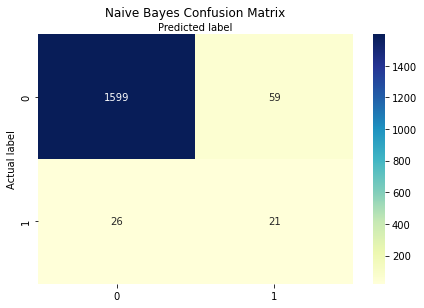

In [19]:
confusion_matrix(naivebayes, x_test, y_test, 'Naive Bayes Confusion Matrix')

In [20]:
model_metrics(naivebayes, x_test, y_test)

GaussianNB()
Accuracy: 0.9501466275659824
  Compare with Null Accuracy: 0.9724340175953079
Precision: 0.2625
Sensitivity: 0.44680851063829785
Specificity: 0.9644149577804584
False Positive Rate: 0.03558504221954162
F1 score: 0.3307086614173228


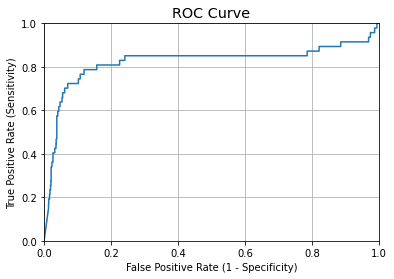

In [21]:
model_roc(naivebayes, x_test, y_test)

# Support Vector Machine

In [22]:
from sklearn import svm
linsvm = svm.SVC(kernel='linear', probability=True)
linsvm.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

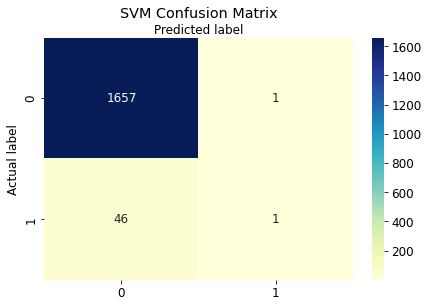

In [23]:
confusion_matrix(linsvm, x_test, y_test, 'SVM Confusion Matrix')

In [24]:
model_metrics(linsvm, x_test, y_test)

SVC(kernel='linear', probability=True)
Accuracy: 0.9724340175953079
  Compare with Null Accuracy: 0.9724340175953079
Precision: 0.5
Sensitivity: 0.02127659574468085
Specificity: 0.9993968636911942
False Positive Rate: 0.0006031363088058184
F1 score: 0.04081632653061224


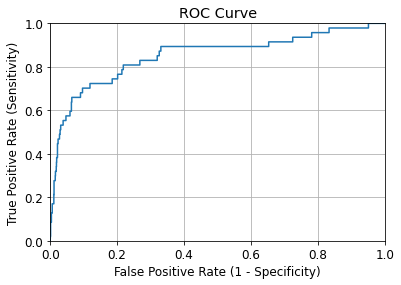

In [25]:
model_roc(linsvm, x_test, y_test)

In [26]:
#Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.967 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.966 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.966 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.966 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.967 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.966 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.966 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.966 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.967 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.967 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [27]:
# print best parameter after tuning
print(grid.best_params_)
 
# print model after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [28]:
#grid_predictions = grid.predict(x_test)
model_metrics(grid, x_test, y_test)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)
Accuracy: 0.9724340175953079
  Compare with Null Accuracy: 0.9724340175953079
Precision: 0.5
Sensitivity: 0.02127659574468085
Specificity: 0.9993968636911942
False Positive Rate: 0.0006031363088058184
F1 score: 0.04081632653061224


# Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

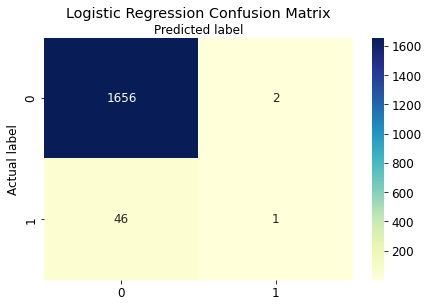

In [30]:
confusion_matrix(logreg, x_test, y_test, 'Logistic Regression Confusion Matrix')

In [31]:
model_metrics(logreg, x_test, y_test)

LogisticRegression()
Accuracy: 0.9718475073313783
  Compare with Null Accuracy: 0.9724340175953079
Precision: 0.3333333333333333
Sensitivity: 0.02127659574468085
Specificity: 0.9987937273823885
False Positive Rate: 0.0012062726176115257
F1 score: 0.04


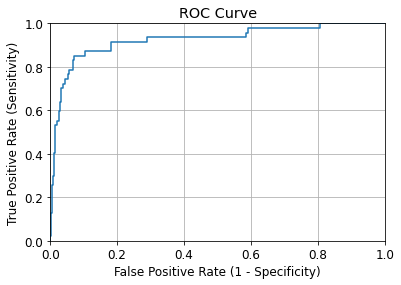

In [32]:
model_roc(logreg, x_test, y_test)

# Tree-based Classifiers

In [33]:
#classifiers require fewer assumptions, so we use all features
cor_matrix = bankrupt.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
b4 = bankrupt.drop(to_drop, axis=1)

xtree = b4.drop(['Bankrupt?'], axis=1)
ytree = b4['Bankrupt?']

In [34]:
from sklearn.model_selection import train_test_split
xt_train, xt_test, yt_train, yt_test = train_test_split(xtree, ytree, test_size=0.2, random_state=36)

## Random Forest

In [35]:
#import classifer
from sklearn.ensemble import RandomForestClassifier

#instantiate the estimator
rfc = RandomForestClassifier()

#fit the model with the training data
rfc.fit(xt_train, yt_train)

RandomForestClassifier()

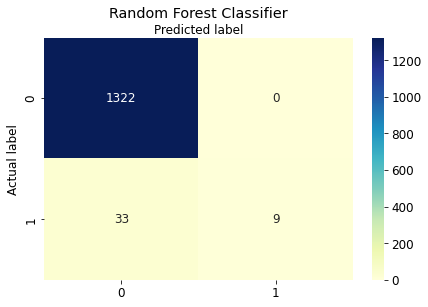

In [36]:
confusion_matrix(rfc, xt_test, yt_test, 'Random Forest Classifier')

In [37]:
model_metrics(rfc, xt_test, yt_test)

RandomForestClassifier()
Accuracy: 0.9758064516129032
  Compare with Null Accuracy: 0.969208211143695
Precision: 1.0
Sensitivity: 0.21428571428571427
Specificity: 1.0
False Positive Rate: 0.0
F1 score: 0.35294117647058826


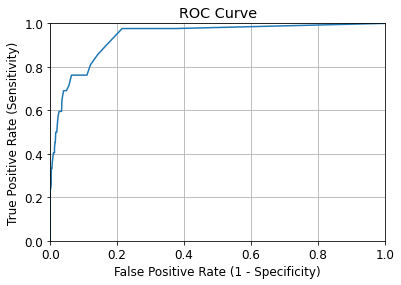

In [38]:
model_roc(rfc, xt_test, yt_test)

### Hyperparameter Tuning

In [39]:
from sklearn.model_selection import RandomizedSearchCV

In [40]:
#specify hyperparameter distributions
nest_range = list(range(50, 400))
max_features_range = list(range(1, 20))
max_depth_range = list(range(1, 25))
splitting_criteria_range = ['gini', 'entropy']

param_dist = dict(n_estimators=nest_range, max_features=max_features_range, max_depth=max_depth_range, criterion=splitting_criteria_range)
#print(param_dist)
#Randomized Hyperparameter Search
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='accuracy', n_iter=10)
rand.fit(xtree, ytree)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 7

In [41]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9683239241929025
{'n_estimators': 222, 'max_features': 15, 'max_depth': 17, 'criterion': 'entropy'}


In [46]:
# run the best model
bestrfc = RandomForestClassifier(n_estimators=222, max_features=15, max_depth=17, criterion='entropy')
bestrfc.fit(xtree, ytree)

RandomForestClassifier(criterion='entropy', max_depth=17, max_features=15,
                       n_estimators=222)

In [47]:
model_metrics(bestrfc, xt_test, yt_test)

RandomForestClassifier(criterion='entropy', max_depth=17, max_features=15,
                       n_estimators=222)
Accuracy: 1.0
  Compare with Null Accuracy: 0.969208211143695
Precision: 1.0
Sensitivity: 1.0
Specificity: 1.0
False Positive Rate: 0.0
F1 score: 1.0


## Gradient Boosted Trees

In [49]:
#import classifer
from sklearn.ensemble import GradientBoostingClassifier

#instantiate the estimator
gbc = GradientBoostingClassifier()

#fit the model with the training data
gbc.fit(xt_train, yt_train)

GradientBoostingClassifier()

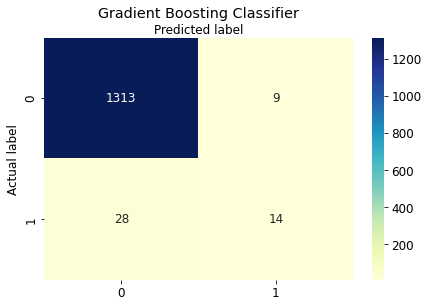

In [50]:
confusion_matrix(gbc, xt_test, yt_test, 'Gradient Boosting Classifier')

In [51]:
model_metrics(gbc, xt_test, yt_test)

GradientBoostingClassifier()
Accuracy: 0.9728739002932552
  Compare with Null Accuracy: 0.969208211143695
Precision: 0.6086956521739131
Sensitivity: 0.3333333333333333
Specificity: 0.9931921331316188
False Positive Rate: 0.006807866868381196
F1 score: 0.4307692307692308


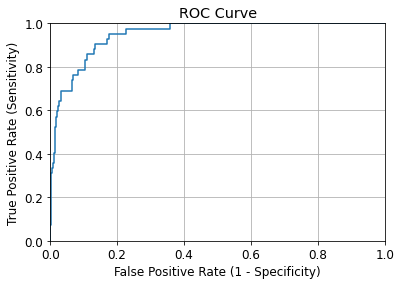

In [52]:
model_roc(gbc, xt_test, yt_test)

### Hyperparameter Tuning

In [66]:
#specify hyperparameter distributions
nest_range = list(range(50, 400))
max_features_range = list(range(1, 10))
max_depth_range = list(range(1, 25))
splitting_criteria_range = ['friedman_mse', 'squared_error']

param_dist = dict(n_estimators=nest_range, max_features=max_features_range, max_depth=max_depth_range, criterion=splitting_criteria_range)
#print(param_dist)
#Randomized Hyperparameter Search
gbrand = RandomizedSearchCV(gbc, param_dist, cv=5, scoring='accuracy', n_iter=10)
gbrand.fit(xtree, ytree)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                       

In [67]:
# examine the best model
print(gbrand.best_score_)
print(gbrand.best_params_)

0.9671507994053139
{'n_estimators': 240, 'max_features': 1, 'max_depth': 17, 'criterion': 'friedman_mse'}


In [69]:
# run the best model
bestgbc = GradientBoostingClassifier(n_estimators=240, max_features=1, max_depth=17, criterion='friedman_mse')
bestgbc.fit(xtree, ytree)

GradientBoostingClassifier(max_depth=17, max_features=1, n_estimators=240)

In [70]:
model_metrics(bestgbc, xt_test, yt_test)

GradientBoostingClassifier(max_depth=17, max_features=1, n_estimators=240)
Accuracy: 1.0
  Compare with Null Accuracy: 0.969208211143695
Precision: 1.0
Sensitivity: 1.0
Specificity: 1.0
False Positive Rate: 0.0
F1 score: 1.0


## Extra Trees

In [60]:
#import classifer
from sklearn.ensemble import ExtraTreesClassifier

#instantiate the estimator
etc = ExtraTreesClassifier()

#fit the model with the training data
etc.fit(xt_train, yt_train)

ExtraTreesClassifier()

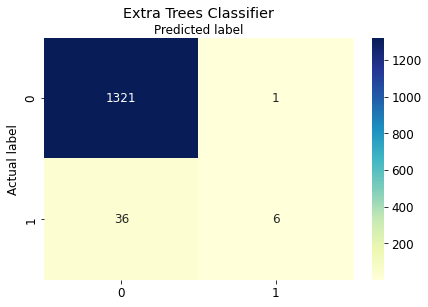

In [61]:
confusion_matrix(etc, xt_test, yt_test, 'Extra Trees Classifier')

In [62]:
model_metrics(etc, xt_test, yt_test)

ExtraTreesClassifier()
Accuracy: 0.9728739002932552
  Compare with Null Accuracy: 0.969208211143695
Precision: 0.8571428571428571
Sensitivity: 0.14285714285714285
Specificity: 0.9992435703479576
False Positive Rate: 0.0007564296520423675
F1 score: 0.24489795918367344


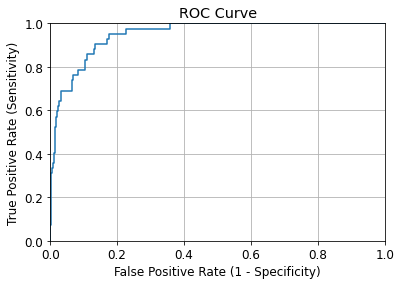

In [63]:
model_roc(gbc, xt_test, yt_test)

### Hyperparameter Tuning

In [65]:
#specify hyperparameter distributions
nest_range = list(range(50, 250))
max_features_range = list(range(1, 10))
max_depth_range = list(range(1, 25))
splitting_criteria_range = ['gini', 'entropy']

param_dist = dict(n_estimators=nest_range, max_features=max_features_range, max_depth=max_depth_range, criterion=splitting_criteria_range)
#print(param_dist)
#Randomized Hyperparameter Search
etcrand = RandomizedSearchCV(etc, param_dist, cv=5, scoring='accuracy', n_iter=10)
etcrand.fit(xtree, ytree)

RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74, 75, 76, 77, 78, 79, ...]},
         

In [68]:
# examine the best model
print(etcrand.best_score_)
print(etcrand.best_params_)

0.968763595054036
{'n_estimators': 58, 'max_features': 8, 'max_depth': 8, 'criterion': 'gini'}


In [71]:
# run the best model
bestgbc = ExtraTreesClassifier(n_estimators=58, max_features=8, max_depth=8, criterion='gini')
bestgbc.fit(xtree, ytree)

ExtraTreesClassifier(max_depth=8, max_features=8, n_estimators=58)

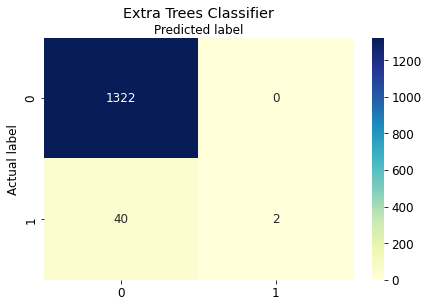

In [72]:
confusion_matrix(bestgbc, xt_test, yt_test, 'Extra Trees Classifier')

In [73]:
model_metrics(bestgbc, xt_test, yt_test)

ExtraTreesClassifier(max_depth=8, max_features=8, n_estimators=58)
Accuracy: 0.9706744868035191
  Compare with Null Accuracy: 0.969208211143695
Precision: 1.0
Sensitivity: 0.047619047619047616
Specificity: 1.0
False Positive Rate: 0.0
F1 score: 0.0909090909090909


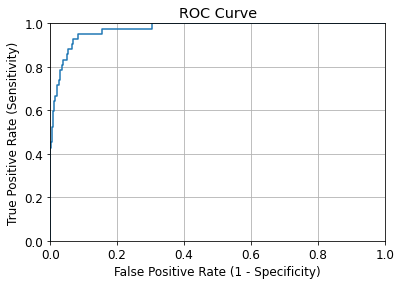

In [74]:
model_roc(bestgbc, xt_test, yt_test)